In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Flatten,LSTM, Reshape, Dense, MaxPool2D, concatenate, Lambda, BatchNormalization, Dropout
from tensorflow.keras import Model, Input
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
from tensorflow.keras import regularizers

In [19]:
MONTHS = ['01','02','03','04','05','06','07','08','09','10','11','12']
LOCATIONS = ['Alpnach']
YEAR = '2018'
EXPO = '10'

# Data reading
def read_data(month, location):
    dataset = pd.read_csv(f'expo{EXPO}_{location}2018/{month}_2018_complete_exposure{EXPO}/{month}_2018_expo{EXPO}_resized.csv')
    images = []
    string_lists = os.listdir(f'expo{EXPO}_{location}{YEAR}/{month}_{YEAR}_complete_exposure{EXPO}/resized/')
    dir_path = f'expo{EXPO}_{location}{YEAR}/{month}_2018_complete_exposure{EXPO}/resized/'

    for filepath in string_lists:
        route = os.path.join(dir_path, filepath)
        image = cv2.imread(route,0)
        images.append(image)

    images = np.array(images)
    return images, dataset[['Irradiance','Zenith','Hour','Pressure','Humidity','Temperature']]


def connect_data():
    images_completed, df_completed = read_data(MONTHS[0], LOCATIONS[0])

    for location in LOCATIONS:
        for month in MONTHS:
            if month == MONTHS[0] and location == LOCATIONS[0] \
                    or not os.path.exists(f'expo{EXPO}_{location}2018/'
                                          f'{month}_2018_complete_exposure{EXPO}/{month}_2018_expo{EXPO}_resized.csv'):
                continue
            images, df = read_data(month, location)
            images_completed = np.concatenate((images_completed, images))
            df_completed = pd.concat([df_completed, df])

    return images_completed, df_completed

In [22]:
# Data preprocessing
images, df = connect_data()

sequence_length = 5
step = 1
sequences_df = np.array([df[i:i + sequence_length] for i in range(0, len(df) - sequence_length + 1, step)])
sequences_im = np.array([images[i:i + sequence_length] for i in range(0, len(images) - sequence_length + 1, step)])
first_elements = np.array(sequences_df[:, 4, 0])

first_elements = first_elements[1:]
sequences_im = sequences_im[:-1]
sequences_df = sequences_df[:-1]
sequences_df_num = np.array(sequences_df)

# Removing cross-day sequences
index_to_remove = 0
for x in sequences_df:
    if  abs(x[0][5] - x[4][5]) > 3 or first_elements[index_to_remove] > 1300:
        first_elements = np.delete(first_elements, index_to_remove, axis=0)
        sequences_im = np.delete(sequences_im, index_to_remove, axis=0)
        sequences_df_num = np.delete(sequences_df_num, index_to_remove, axis=0)
        index_to_remove -= 1
    index_to_remove += 1

train_im, test_im, train_x, test_x, train_y, test_y = train_test_split(sequences_im, sequences_df_num, first_elements, train_size=0.90, shuffle=True, random_state=10)

train_im = np.moveaxis(train_im, 1, -1)/255
test_im = np.moveaxis(test_im, 1, -1) / 255
shape_train = train_x.shape
shape_test = test_x.shape

train_x_2d = train_x.reshape(-1, train_x.shape[-1])
test_x_2d = test_x.reshape(-1, test_x.shape[-1])

scaler = StandardScaler()
scaler.fit(train_x_2d)
train_x_2d = scaler.fit_transform(train_x_2d)
test_x_2d = scaler.fit_transform(test_x_2d)

train_x = train_x_2d.reshape(shape_train)
test_x = test_x_2d.reshape(shape_test)

In [24]:
# Input layers
image_input = Input(shape=(64, 64, 5))
numeric_input = Input(shape=(5,6))

# Conv+Lstm branch
feat_sequence = []
for a in range(5):
    img_rgb = image_input[:, :, :, a:a + 1]
    x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(img_rgb)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D()(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D()(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dense(16, activation='relu')(x)
    feat_sequence.append(x)

feat_sequence = tf.convert_to_tensor(feat_sequence)
feat_sequence = tf.transpose(feat_sequence, perm=(1, 0, 2))

x = LSTM(32, activation='relu')(feat_sequence)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Model(inputs=image_input, outputs=x)

# Mlp+Lstm branch
y = LSTM(32, activation='relu')(numeric_input)
y = Dense(64, activation="relu")(y)
y = Dense(32, activation="relu")(y)
y = Dense(16, activation="relu")(y)

y = Model(inputs=numeric_input, outputs=y)

combined = concatenate([x.output, y.output])

# Final Mlp for regression 
z = Dense(32, activation='relu')(combined)
z = Dense(16, activation='relu')(z)
z = Dense(8, activation='relu')(z)
z = Dense(1, activation='relu')(z)
model = Model(inputs=[x.inputs, y.inputs], outputs=z)

model.summary()

schedule= tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0008,
    decay_steps=1000,
    decay_rate=0.95)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=schedule),
    loss='mae',
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.MeanAbsolutePercentageError(),
             tf.keras.metrics.RootMeanSquaredError()
             ]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(
    x=[train_im, train_x], y=train_y,
    validation_split=0.20,
    epochs=200,
    batch_size=256,
    callbacks=[callback]
)


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 tf.__operators__.getitem_29 (S  (None, 64, 64, 1)   0           ['input_11[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_30 (S  (None, 64, 64, 1)   0           ['input_11[0][0]']               
 licingOpLambda)                                                                                  
                                                                                           

                                                                                                  
 batch_normalization_97 (BatchN  (None, 29, 29, 16)  64          ['conv2d_97[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_100 (Batch  (None, 29, 29, 16)  64          ['conv2d_100[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d_88 (MaxPooling2D  (None, 14, 14, 16)  0           ['batch_normalization_88[0][0]'] 
 )                                                                                                
                                                                                                  
 max_pooli

                                                                                                  
 dense_110 (Dense)              (None, 32)           36896       ['dropout_30[0][0]']             
                                                                                                  
 dense_112 (Dense)              (None, 32)           36896       ['dropout_31[0][0]']             
                                                                                                  
 dense_114 (Dense)              (None, 32)           36896       ['dropout_32[0][0]']             
                                                                                                  
 dense_116 (Dense)              (None, 32)           36896       ['dropout_33[0][0]']             
                                                                                                  
 dense_109 (Dense)              (None, 16)           528         ['dense_108[0][0]']              
          

47/47 [==============================] - 64s 1s/step - loss: 48.2902 - val_loss: 48.6878
Epoch 23/200
47/47 [==============================] - 63s 1s/step - loss: 46.7807 - val_loss: 51.2821
Epoch 24/200
47/47 [==============================] - 63s 1s/step - loss: 46.6492 - val_loss: 48.0916
Epoch 25/200
47/47 [==============================] - 61s 1s/step - loss: 45.9082 - val_loss: 48.3215
Epoch 26/200
47/47 [==============================] - 62s 1s/step - loss: 45.5693 - val_loss: 50.6683
Epoch 27/200
47/47 [==============================] - 62s 1s/step - loss: 46.4539 - val_loss: 46.6347
Epoch 28/200
47/47 [==============================] - 61s 1s/step - loss: 44.7927 - val_loss: 52.6175
Epoch 29/200
47/47 [==============================] - 65s 1s/step - loss: 45.4740 - val_loss: 49.0262
Epoch 30/200
47/47 [==============================] - 66s 1s/step - loss: 46.0422 - val_loss: 45.9284
Epoch 31/200
47/47 [==============================] - 62s 1s/step - loss: 44.3927 - val_loss: 4

In [25]:
# Statistical calculation and prediction conclusion
train_predictions = model.predict([train_im, train_x])
test_predictions = model.predict([test_im, test_x])

train_mape = mean_absolute_percentage_error(train_y, train_predictions)
test_mape = mean_absolute_percentage_error(test_y, test_predictions)

train_mae = mean_absolute_error(train_y, train_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)

train_rmse = sqrt(mean_squared_error(train_y, train_predictions))
test_rmse = sqrt(mean_squared_error(test_y, test_predictions))

r2 = r2_score(test_y, test_predictions)
r2 = r2_score(train_y, train_predictions)

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

print("Train MAPE:", train_mape)
print("Test MAPE:", test_mape)

r2 = r2_score(test_y, test_predictions)
print("Test R^2 Score: {:.5f}".format(r2))
r2 = r2_score(train_y, train_predictions)
print("Train R^2 Score: {:.5f}".format(r2))

52/52 [==============================] - 3s 53ms/step
Train MAE: 47.084720506736566
Test MAE: 49.05735714310251
Train RMSE: 94.30963822203364
Test RMSE: 91.6797371813793
Train MAPE: 0.30981846625933823
Test MAPE: 0.30395324101325794
Test R^2 Score: 0.88867
Train R^2 Score: 0.88375


In [29]:
# visualisation
def plot_los_acc(history):
    training_history = pd.DataFrame.from_dict(history.history)
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.plot(training_history['loss'], label='loss')
    plt.plot(training_history['val_loss'], label='val_loss')
    plt.title('Vývoj trénovacej a validačnej chyby', fontsize=12)
    plt.xlabel('Epochy', fontsize=10)
    plt.ylabel('MAE', fontsize=10)
    plt.legend()
    plt.show()


def plot_true_predicted_difference(test_y, predicted):
    arr = []
    arr2 = []

    for x in predicted:
        arr.append(x[0])
    i = 0
    for y in test_y:
        arr[i] = y - arr[i]
        arr2.append(i)
        i += 1
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title('Trénovacia a validačná absolútna chyba', fontsize=12)
    plt.scatter(arr, arr2)
    plt.show()


def hist_percentage(test_y, predicted):
    true = []
    pred = []
    val_percentage = [[], [], [], [], []]

    for x in predicted:
        pred.append(x[0])
    for y in test_y:
        true.append(y)
    i = 0
    for a in true:
        ape = abs(a - pred[i])
        if ape <= 40 or ape == 0:
            val_percentage[0].append('0-40')
        elif 40 < ape <= 80:
            val_percentage[1].append('40-80')
        elif 80 < ape <= 120:
            val_percentage[2].append('80-120')
        elif 120 < ape <= 150:
            val_percentage[3].append('120-150')
        else:
            val_percentage[4].append('>200')
        i += 1
    for b in val_percentage:
        print(len(b))
    val_percentage = np.array(val_percentage)
    flat_data = val_percentage.flatten()

    fig, ax = plt.subplots(figsize=(4, 4))
    n, bins, patches = ax.hist(flat_data, bins=5, alpha=0.75, edgecolor='black')

    ax.set_title('Absolútne chyby', fontsize=12)
    ax.set_xlabel('Presnosť', fontsize=10)
    ax.set_ylabel('Početnosť', fontsize=10)


    ax.grid(alpha=0.5, linestyle='dashed', linewidth=0.5)
    plt.show()

def plot_r2(true_values, predictions, title='R² Skóre'):
    r2 = r2_score(true_values, predictions)

    plt.figure(figsize=(4, 4))
    plt.scatter(true_values, predictions, alpha=0.5)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r', lw=2)
    plt.xlabel('Skutočné')
    plt.ylabel('Predikované')
    plt.title(title)
    plt.text(0.1, 0.9, f'R² = {r2:.4f}', transform=plt.gca().transAxes, fontsize=14)
    plt.show()

1086
303
98
37
113


C:\Users\maria\AppData\Local\Temp\ipykernel_18616\4219684846.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_percentage = np.array(val_percentage)


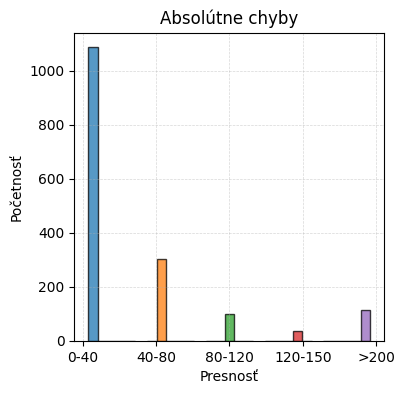

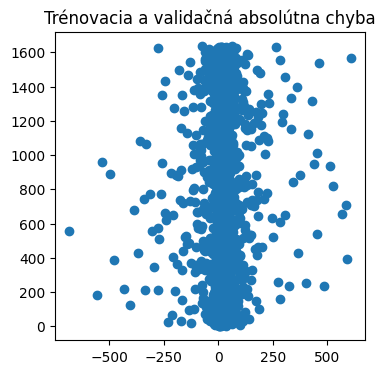

In [30]:
hist_percentage(test_y, test_predictions)
plot_true_predicted_difference(test_y, test_predictions)

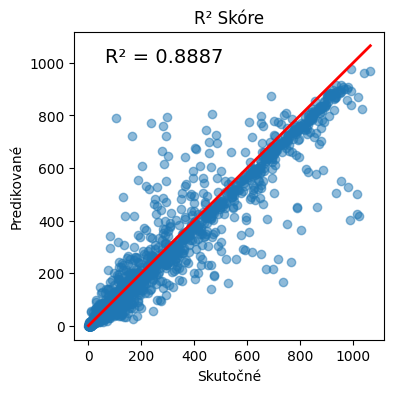

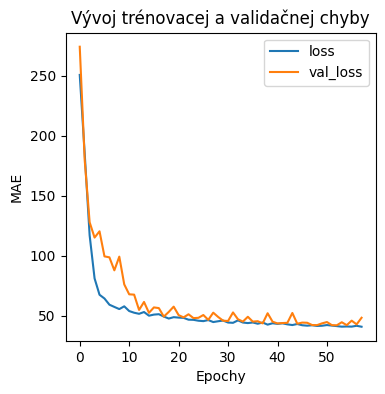

In [31]:
plot_r2(test_y, test_predictions)
plot_los_acc(hist)